# SECTION 4 - SENTIMENT ANALYSIS

### PART 1 - CLASSICAL ANALYSIS
Try using VADER from NLTK or HuggingFace transformers. The aim is to classify each comment in the supervised dataset as positive,
negative, or neutral.

a. Note that for sentiment analysis removing some stopwords (e.g., “not”, “never”, “no”) may
be harmful. Slightly adjust your preprocessing pipeline if you deem it useful.

b. What is the overall sentiment distribution across all comments?

c. Visualize sentiment distribution per subreddit using bar charts or heatmaps.

d. Does sentiment correlate with gender?

## 0. Setup and Data

In [1]:
# Install required packages
!pip install pandas numpy matplotlib seaborn nltk scipy

In [2]:
import pandas as pd
import numpy as np
import matplotlib. pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment. vader import SentimentIntensityAnalyzer
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Download VADER lexicon
nltk.download('vader_lexicon')
# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\rocca\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
# Load the supervised dataset
# For sentiment analysis, we need the original text with stopwords intact

df_supervised = pd.read_csv('../data/data_supervised.csv')
df_target = pd.read_csv('../data/target_supervised.csv')

print(f"Supervised dataset shape: {df_supervised. shape}")
print(f"Target dataset shape: {df_target.shape}")
print(f"\nColumns in supervised data: {df_supervised.columns.tolist()}")
print(f"Columns in target data: {df_target.columns.tolist()}")

Supervised dataset shape: (296042, 4)
Target dataset shape: (5000, 2)

Columns in supervised data: ['author', 'subreddit', 'created_utc', 'body']
Columns in target data: ['author', 'gender']


In [4]:
# Preview the data
print("Sample comments:")
df_supervised.head()

Sample comments:


,author,subreddit,created_utc,body
0,Shamus_Aran,mylittlepony,1.388534e+09,I don't think we'd get nearly as much fanficti...
1,Riddance,sex,1.388534e+09,"Thanks. I made it up, that's how I got over my..."
2,Secret_Wizard,DragonsDogma,1.388534e+09,Are you sure you aren't confusing Cyclops (the...
3,Penultimatum,malefashionadvice,1.388534e+09,dont do this to me bro
4,7-SE7EN-7,todayilearned,1.388534e+09,That's what we do when we can't find a mate


## 1. PREPROCESSING
Remember that is important to NOT remove negation words like "not", "never", "no" as they change the sentiment of a sentence.

Thus we apply minimal preprocessing that preserves sentiment-bearing words.

In [5]:
import html
import re

def preprocess_for_sentiment(text):
    if pd.isna(text):
        return ""
    text = str(text)
    # Decode HTML entities (e.g., &amp; -> &)
    text = html.unescape(text)
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Remove subreddit and user references (r/...  and u/... )
    text = re.sub(r'r/\w+|u/\w+', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply preprocessing
df_supervised['body_sentiment'] = df_supervised['body'].apply(preprocess_for_sentiment)

print("Preprocessing complete!")
print(f"Empty bodies after preprocessing: {(df_supervised['body_sentiment'] == '').sum()}")

Preprocessing complete!
Empty bodies after preprocessing: 987


In [6]:
# Show comparison between original and preprocessed text
comparison_df = df_supervised[['body', 'body_sentiment']].head(5)
for idx, row in comparison_df.iterrows():
    print(f"--- Comment {idx} ---")
    print(f"Original: {row['body'][:200]}..." if len(str(row['body'])) > 200 else f"Original: {row['body']}")
    print(f"Preprocessed: {row['body_sentiment'][:200]}..." if len(row['body_sentiment']) > 200 else f"Preprocessed:  {row['body_sentiment']}")
    print()

--- Comment 0 ---
Original: I don't think we'd get nearly as much fanfiction and pictures shipping Ban-Ban and Lyro. Just saying.
Preprocessed:  I don't think we'd get nearly as much fanfiction and pictures shipping Ban-Ban and Lyro. Just saying.

--- Comment 1 ---
Original: Thanks. I made it up, that's how I got over my first heart break. 
Preprocessed:  Thanks. I made it up, that's how I got over my first heart break.

--- Comment 2 ---
Original: Are you sure you aren't confusing Cyclops (the easiest boss monster) for Ogres? I'm talking about [these guys](http://i.imgur.com/c3YKPdI.jpg)

Maybe I'm just a bad player... But every time I faced on...
Preprocessed: Are you sure you aren't confusing Cyclops (the easiest boss monster) for Ogres? I'm talking about [these guys]( Maybe I'm just a bad player... But every time I faced one on my first playthrough, all m...

--- Comment 3 ---
Original: dont do this to me bro
Preprocessed:  dont do this to me bro

--- Comment 4 ---
Original: That's

## 3. Sentiment Analysis with VADER

**VADER (Valence Aware Dictionary and sEntiment Reasoner)** is a lexicon and rule-based sentiment analysis tool specifically attuned to sentiments expressed in social media.

VADER returns 4 scores:
- `neg`: Negative sentiment proportion
- `neu`: Neutral sentiment proportion
- `pos`: Positive sentiment proportion
- `compound`: Normalized, weighted composite score (-1 to +1)

Classification thresholds (standard):
- Positive: compound >= 0.05
- Negative: compound <= -0.05
- Neutral: -0.05 < compound < 0.05

In [7]:
from tqdm import tqdm
tqdm.pandas()

# Initialize VADER
sia = SentimentIntensityAnalyzer()

def get_sentiment_scores(text):
    if not text or text == "":
        return {'neg': 0, 'neu': 1, 'pos': 0, 'compound': 0}
    return sia.polarity_scores(text)

def classify_sentiment(compound_score):
    if compound_score >= 0.05:
        return 'positive'
    elif compound_score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

print("Analyzing sentiment for all comments... ")
sentiment_scores = df_supervised['body_sentiment'].progress_apply(get_sentiment_scores)

# Extract individual scores
df_supervised['sentiment_neg'] = sentiment_scores. apply(lambda x: x['neg'])
df_supervised['sentiment_neu'] = sentiment_scores.apply(lambda x: x['neu'])
df_supervised['sentiment_pos'] = sentiment_scores. apply(lambda x: x['pos'])
df_supervised['sentiment_compound'] = sentiment_scores.apply(lambda x: x['compound'])

# Classify sentiment
df_supervised['sentiment_label'] = df_supervised['sentiment_compound'].apply(classify_sentiment)

print("\nSentiment analysis complete!")

Analyzing sentiment for all comments... 


100%|██████████| 296042/296042 [01:15<00:00, 3923.86it/s]



Sentiment analysis complete!


In [8]:
# Preview results
df_supervised[['body_sentiment', 'sentiment_compound', 'sentiment_label']]. head(10)

,body_sentiment,sentiment_compound,sentiment_label
0,I don't think we'd get nearly as much fanficti...,0.0000,neutral
1,"Thanks. I made it up, that's how I got over my...",0.4404,positive
2,Are you sure you aren't confusing Cyclops (the...,-0.4804,negative
3,dont do this to me bro,0.0000,neutral
4,That's what we do when we can't find a mate,0.0000,neutral
5,Damn I love this question. Here's what I think...,0.9060,positive
6,Sorry about that one post btw lol. I hope it d...,0.0858,positive
7,Ad 1 & 2. Right. I was mistaken. Ad 3. I'm not...,-0.6597,negative
8,I thought it was Colm Meaney whenever he's in ...,-0.0772,negative
9,FAck. Looks like 4 mins.,0.3612,positive


## 4. Sentiment Distribution (Task 1b)

In [9]:
# Calculate sentiment distribution
sentiment_counts = df_supervised['sentiment_label'].value_counts()
sentiment_percentages = df_supervised['sentiment_label'].value_counts(normalize=True) * 100

print("Overall Sentiment Distribution:")
print("=" * 40)
for label in ['positive', 'neutral', 'negative']:
    count = sentiment_counts. get(label, 0)
    pct = sentiment_percentages.get(label, 0)
    print(f"{label. capitalize():10s}:  {count:>7,} comments ({pct:.2f}%)")
print(f"{'Total':10s}: {len(df_supervised):>7,} comments")

Overall Sentiment Distribution:
Positive  :  135,733 comments (45.85%)
Neutral   :   84,322 comments (28.48%)
Negative  :   75,987 comments (25.67%)
Total     : 296,042 comments


In [10]:
# Compound score statistics
print("\nCompound Score Statistics:")
print(df_supervised['sentiment_compound'].describe())


Compound Score Statistics:
count    296042.000000
mean          0.130114
std           0.485850
min          -0.999800
25%          -0.077200
50%           0.000000
75%           0.510600
max           0.999800
Name: sentiment_compound, dtype: float64


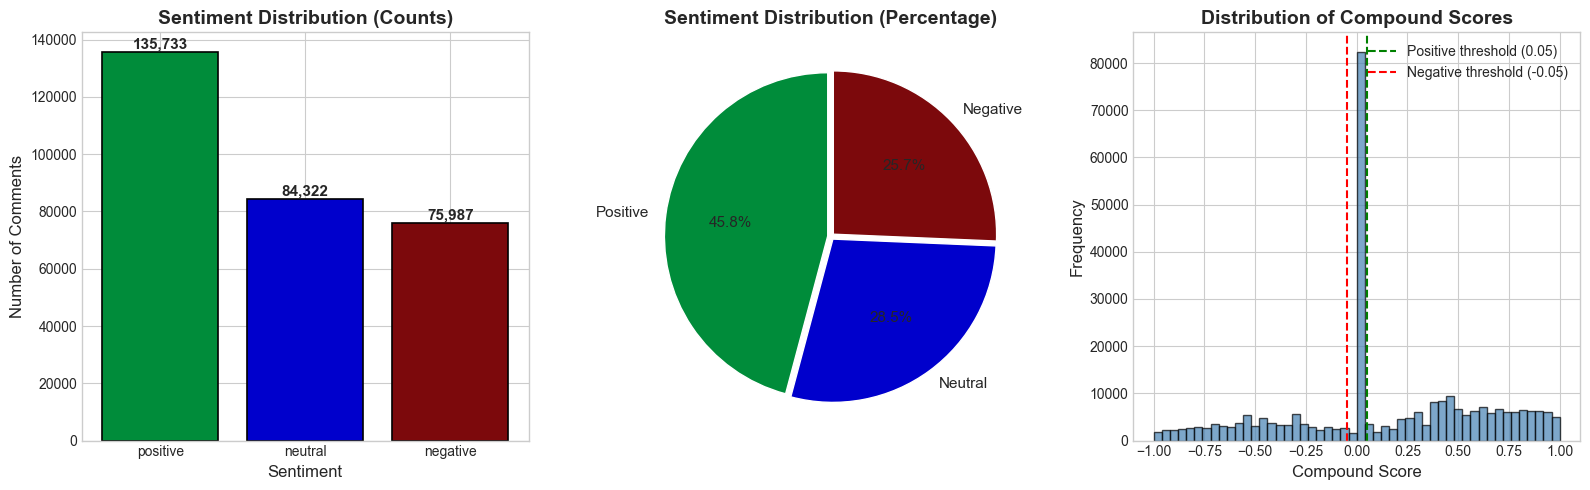


Compound Score Statistics:
count    296042.000000
mean          0.130114
std           0.485850
min          -0.999800
25%          -0.077200
50%           0.000000
75%           0.510600
max           0.999800
Name: sentiment_compound, dtype: float64


In [11]:
# Visualize sentiment distribution
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Bar chart of sentiment counts
colors = {'positive': '#008C3A', 'neutral': '#0000CC', 'negative':  '#7C090C'}
order = ['positive', 'neutral', 'negative']

ax1 = axes[0]
bars = ax1.bar(order, [sentiment_counts. get(s, 0) for s in order],
               color=[colors[s] for s in order], edgecolor='black', linewidth=1.2)
ax1.set_xlabel('Sentiment', fontsize=12)
ax1.set_ylabel('Number of Comments', fontsize=12)
ax1.set_title('Sentiment Distribution (Counts)', fontsize=14, fontweight='bold')

# Add value labels on bars
for bar, label in zip(bars, order):
    height = bar.get_height()
    ax1.annotate(f'{int(height):,}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                ha='center', va='bottom', fontsize=11, fontweight='bold')

# 2. Pie chart
ax2 = axes[1]
sizes = [sentiment_counts.get(s, 0) for s in order]
explode = (0.02, 0.02, 0.02)
ax2.pie(sizes, labels=[s.capitalize() for s in order], autopct='%1.1f%%',
        colors=[colors[s] for s in order], explode=explode,
        startangle=90, textprops={'fontsize': 11})
ax2.set_title('Sentiment Distribution (Percentage)', fontsize=14, fontweight='bold')

# 3. Distribution of compound scores
ax3 = axes[2]
ax3.hist(df_supervised['sentiment_compound'], bins=50, color='steelblue',
         edgecolor='black', alpha=0.7)
ax3.axvline(x=0.05, color='green', linestyle='--', label='Positive threshold (0.05)')
ax3.axvline(x=-0.05, color='red', linestyle='--', label='Negative threshold (-0.05)')
ax3.set_xlabel('Compound Score', fontsize=12)
ax3.set_ylabel('Frequency', fontsize=12)
ax3.set_title('Distribution of Compound Scores', fontsize=14, fontweight='bold')
ax3.legend(loc='upper right')

plt.tight_layout()
plt.savefig('sentiment_overall_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Statistics on compound scores
print("\nCompound Score Statistics:")
print(df_supervised['sentiment_compound'].describe())

## 6. Sentiment Distribution per Subreddit (Task 1c)

**Question:** Visualize sentiment distribution per subreddit using bar charts or heatmaps.

In [12]:
# Calculate sentiment distribution per subreddit
subreddit_sentiment = df_supervised.groupby(['subreddit', 'sentiment_label']).size().unstack(fill_value=0)

# Calculate percentages
subreddit_sentiment_pct = subreddit_sentiment.div(subreddit_sentiment.sum(axis=1), axis=0) * 100

# Reorder columns if they exist
cols_order = ['positive', 'neutral', 'negative']
cols_present = [c for c in cols_order if c in subreddit_sentiment_pct.columns]
subreddit_sentiment_pct = subreddit_sentiment_pct[cols_present]

# Get top 20 subreddits by comment count
top_subreddits = df_supervised['subreddit'].value_counts().head(20).index.tolist()

print(f"Total unique subreddits: {df_supervised['subreddit'].nunique()}")
print(f"\nTop 20 subreddits by comment count:")
print(df_supervised['subreddit'].value_counts().head(20))


Total unique subreddits: 3468

Top 20 subreddits by comment count:
subreddit
AskReddit          30884
ExploreFiction     15045
AskWomen            8318
AskMen              7734
AdviceAnimals       6866
funny               6288
nfl                 5657
pics                4959
RatedRFiction       4438
nba                 3834
WTF                 3555
CFB                 3197
todayilearned       3097
MakeupAddiction     2883
gaming              2712
videos              2707
hockey              2407
IAmA                2352
TumblrInAction      2017
teenagers           1942
Name: count, dtype: int64


In [13]:
# Average compound score per subreddit
subreddit_compound = df_supervised.groupby('subreddit')['sentiment_compound'].agg(['mean', 'std', 'count'])
subreddit_compound = subreddit_compound.sort_values('mean', ascending=False)

# Filter subreddits with at least 100 comments for reliability
subreddit_compound_filtered = subreddit_compound[subreddit_compound['count'] >= 100]

print("\nMost POSITIVE Subreddits (min 100 comments):")
print(subreddit_compound_filtered.head(10))

print("\nMost NEGATIVE Subreddits (min 100 comments):")
print(subreddit_compound_filtered.tail(10))



Most POSITIVE Subreddits (min 100 comments):
                        mean       std  count
subreddit                                    
RandomActsofMakeup  0.593569  0.422735    964
weddingplanning     0.554906  0.445487    153
Indiemakeupandmore  0.538075  0.433909    487
LongDistance        0.490505  0.491491    147
FancyFollicles      0.472607  0.464413    160
mtgcube             0.448586  0.537424    140
GoneWildPlus        0.445360  0.354497    132
amiugly             0.444498  0.396820    219
Rateme              0.427587  0.437820    187
loseit              0.419351  0.513257    299

Most NEGATIVE Subreddits (min 100 comments):
                        mean       std  count
subreddit                                    
conspiratard       -0.066244  0.486022    368
JusticePorn        -0.069188  0.514890    127
conservatives      -0.081775  0.549137    632
badhistory         -0.089309  0.512528    193
Conservatives_R_Us -0.113001  0.533215    179
rage               -0.118322  0.49

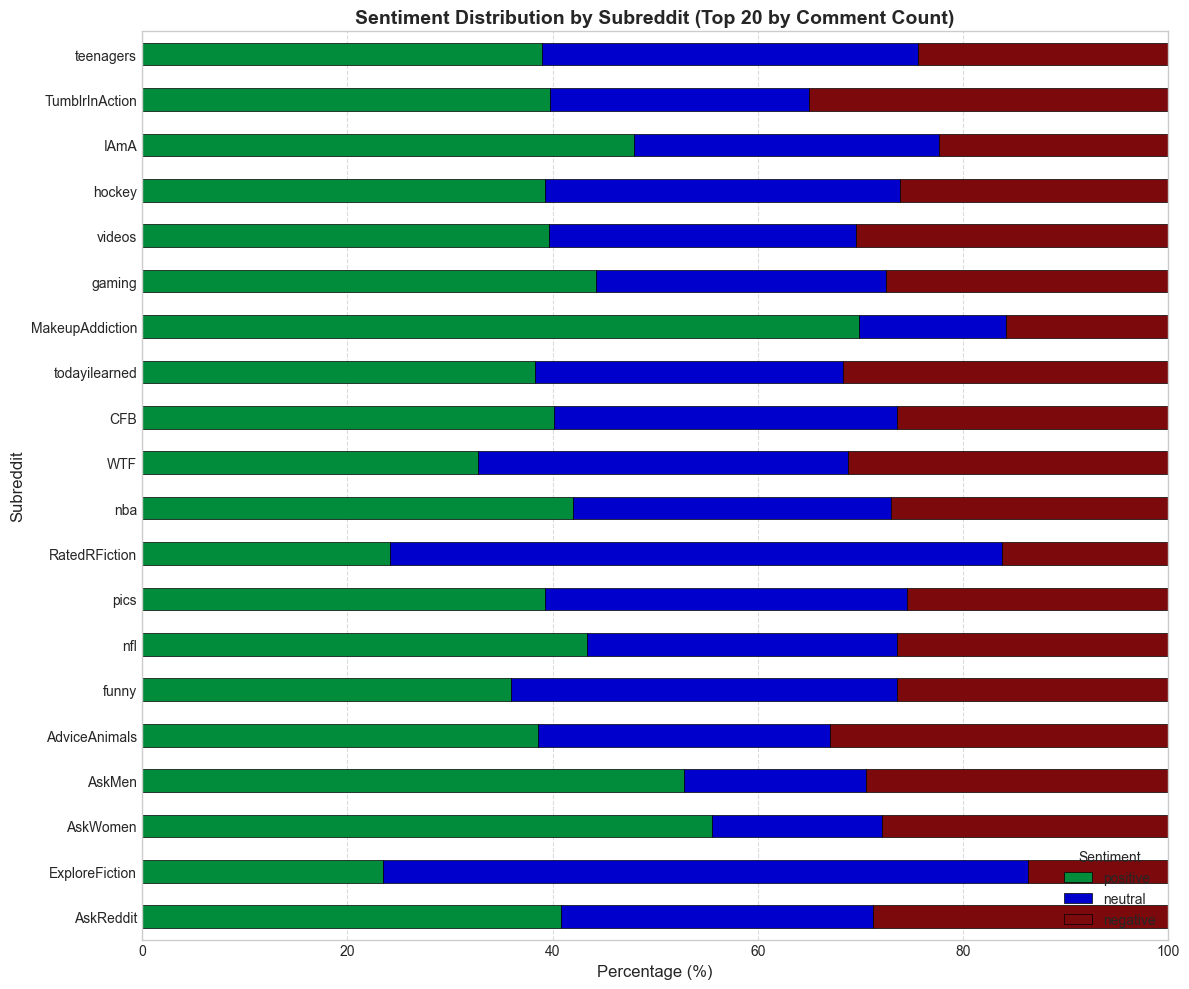

In [14]:
# Stacked horizontal bar chart for top 20 subreddits
fig, ax = plt.subplots(figsize=(12, 10))

# Filter to top subreddits
plot_data = subreddit_sentiment_pct.loc[top_subreddits][cols_present]

# Create stacked bar chart
plot_data.plot(kind='barh', stacked=True, ax=ax,
               color=[colors. get(c, 'gray') for c in cols_present],
               edgecolor='black', linewidth=0.5)

ax.set_xlabel('Percentage (%)', fontsize=12)
ax.set_ylabel('Subreddit', fontsize=12)
ax.set_title('Sentiment Distribution by Subreddit (Top 20 by Comment Count)', fontsize=14, fontweight='bold')
ax.legend(title='Sentiment', loc='lower right', fontsize=10)
ax.set_xlim(0, 100)
ax.xaxis.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('4.2_sentiment_by_subreddit_bar.png', dpi=150, bbox_inches='tight')
plt.show()


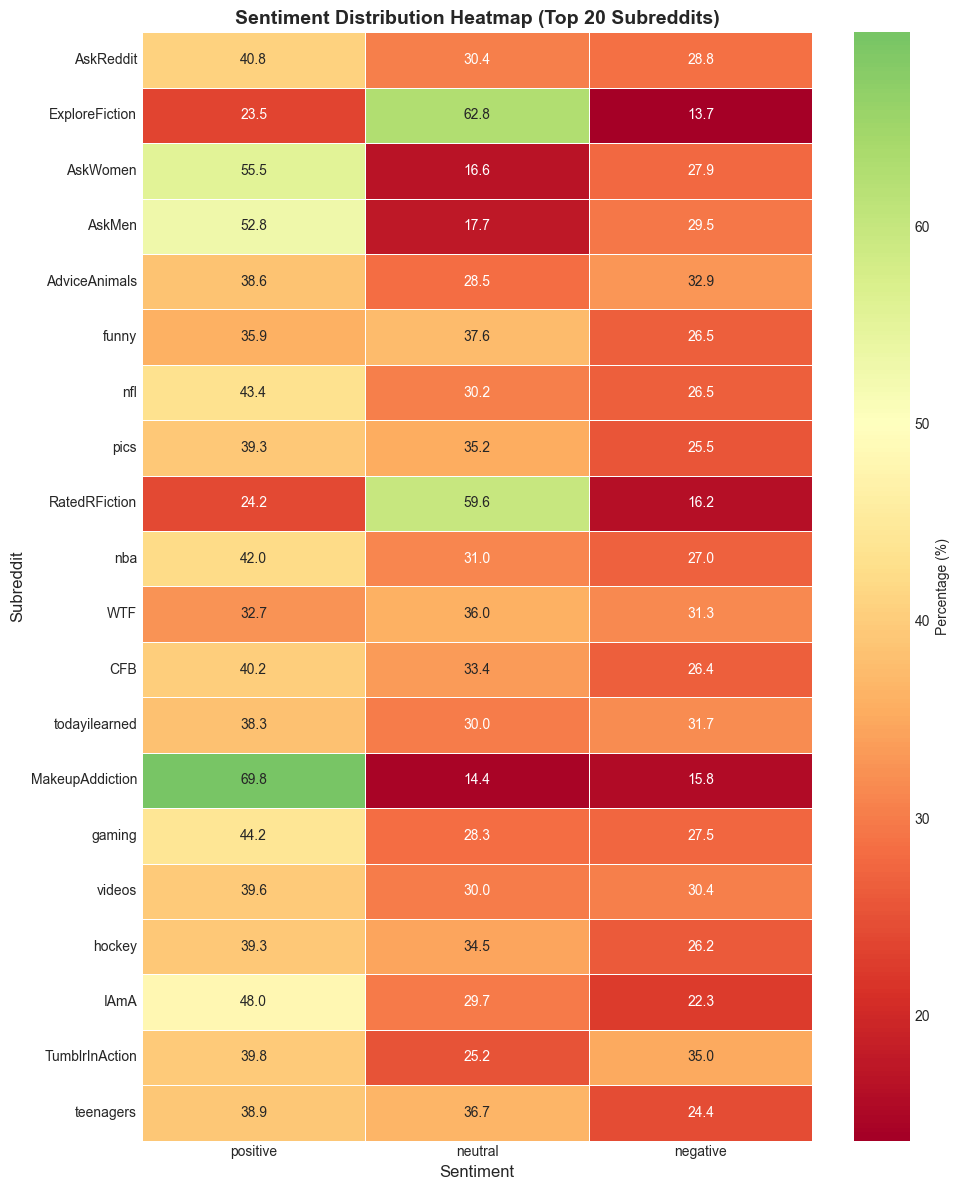

In [15]:
# Heatmap of sentiment distribution
fig, ax = plt.subplots(figsize=(10, 12))

# Prepare heatmap data
heatmap_data = subreddit_sentiment_pct.loc[top_subreddits][cols_present]

# Create heatmap
sns.heatmap(heatmap_data,
            annot=True,
            fmt='.1f',
            cmap='RdYlGn',
            center=50,
            ax=ax,
            linewidths=0.5,
            cbar_kws={'label': 'Percentage (%)'})

ax.set_xlabel('Sentiment', fontsize=12)
ax.set_ylabel('Subreddit', fontsize=12)
ax.set_title('Sentiment Distribution Heatmap (Top 20 Subreddits)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('4.3_sentiment_by_subreddit_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()


### 6.3 Most Positive and Negative Subreddits


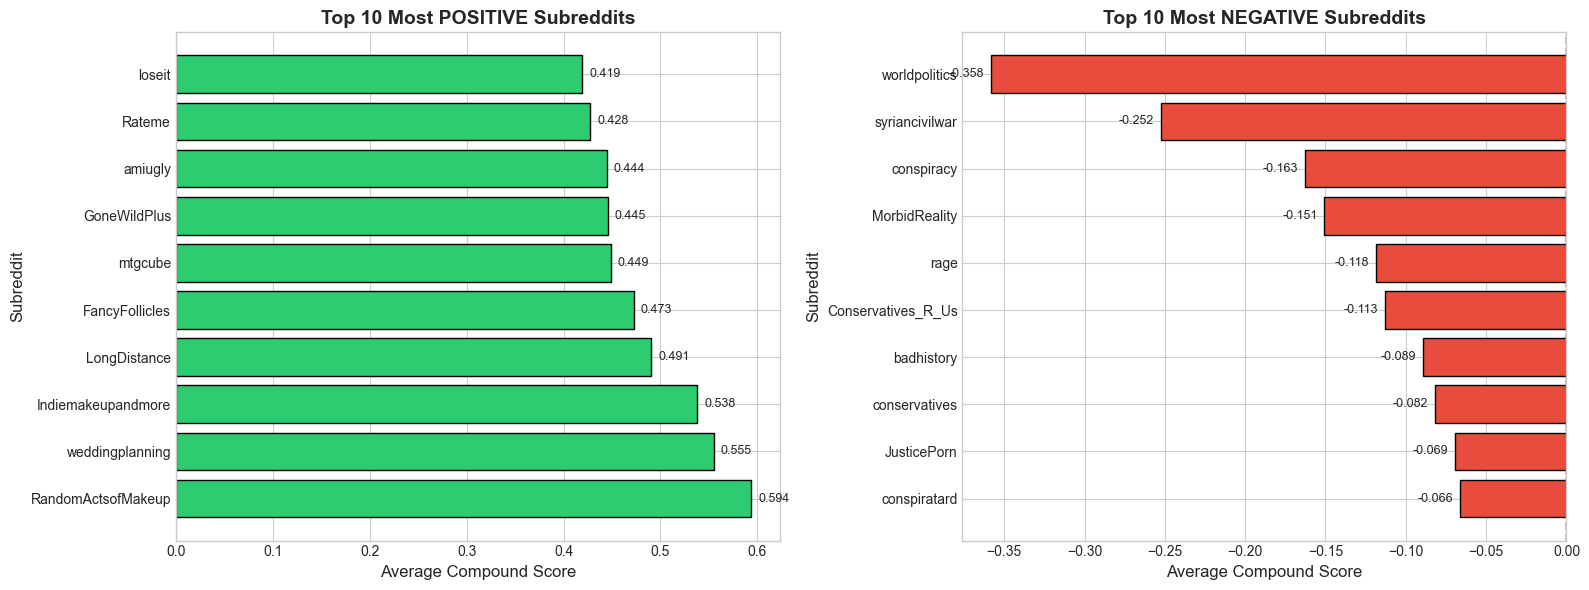

In [16]:
# Bar chart comparing most positive vs most negative subreddits
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 10 most positive subreddits
top_positive = subreddit_compound_filtered.head(10)
ax1 = axes[0]
bars1 = ax1.barh(top_positive. index, top_positive['mean'], color='#2ecc71', edgecolor='black')
ax1.set_xlabel('Average Compound Score', fontsize=12)
ax1.set_ylabel('Subreddit', fontsize=12)
ax1.set_title('Top 10 Most POSITIVE Subreddits', fontsize=14, fontweight='bold')
ax1.axvline(x=0, color='gray', linestyle='--', alpha=0.5)

# Add value labels
for bar in bars1:
    width = bar.get_width()
    ax1.annotate(f'{width:.3f}',
                 xy=(width, bar.get_y() + bar.get_height()/2),
                 ha='left', va='center', fontsize=9, xytext=(5, 0),
                 textcoords='offset points')

# Top 10 most negative subreddits
top_negative = subreddit_compound_filtered.tail(10)
ax2 = axes[1]
bars2 = ax2.barh(top_negative. index, top_negative['mean'], color='#e74c3c', edgecolor='black')
ax2.set_xlabel('Average Compound Score', fontsize=12)
ax2.set_ylabel('Subreddit', fontsize=12)
ax2.set_title('Top 10 Most NEGATIVE Subreddits', fontsize=14, fontweight='bold')
ax2.axvline(x=0, color='gray', linestyle='--', alpha=0.5)

# Add value labels
for bar in bars2:
    width = bar.get_width()
    ax2.annotate(f'{width:.3f}',
                 xy=(width, bar.get_y() + bar.get_height()/2),
                 ha='right' if width < 0 else 'left', va='center', fontsize=9,
                 xytext=(-5 if width < 0 else 5, 0),
                 textcoords='offset points')

plt.tight_layout()
plt.savefig('4.4_sentiment_extreme_subreddits.png', dpi=150, bbox_inches='tight')
plt.show()


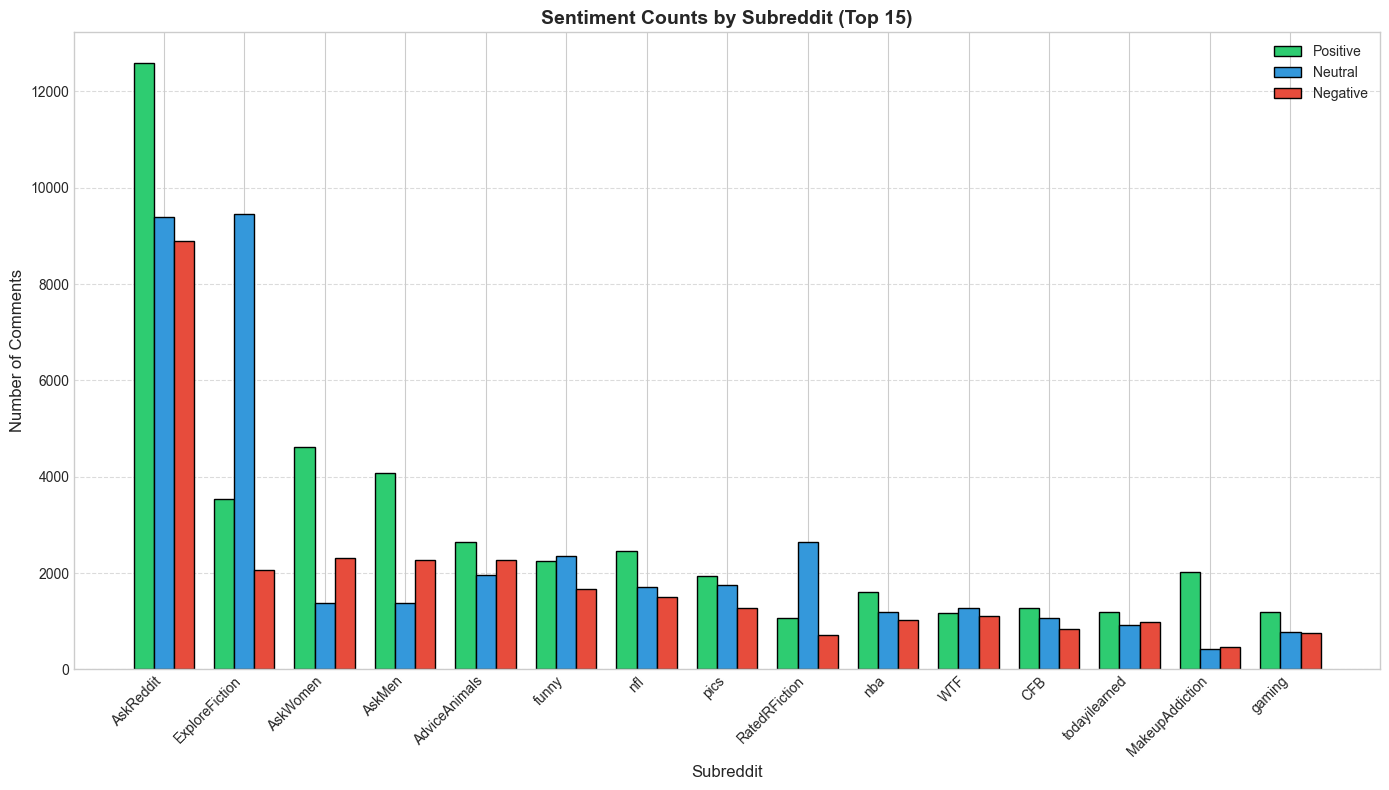

In [17]:
# Grouped bar chart showing actual counts
fig, ax = plt. subplots(figsize=(14, 8))

# Get top 15 subreddits for cleaner visualization
top_15_subs = df_supervised['subreddit'].value_counts().head(15).index.tolist()
plot_counts = subreddit_sentiment. loc[top_15_subs][cols_present]

# Set up bar positions
x = np.arange(len(top_15_subs))
width = 0.25

# Create bars
bars1 = ax.bar(x - width, plot_counts['positive'], width, label='Positive', color='#2ecc71', edgecolor='black')
bars2 = ax.bar(x, plot_counts['neutral'], width, label='Neutral', color='#3498db', edgecolor='black')
bars3 = ax.bar(x + width, plot_counts['negative'], width, label='Negative', color='#e74c3c', edgecolor='black')

ax.set_xlabel('Subreddit', fontsize=12)
ax.set_ylabel('Number of Comments', fontsize=12)
ax.set_title('Sentiment Counts by Subreddit (Top 15)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(top_15_subs, rotation=45, ha='right')
ax.legend()
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('4.5_sentiment_counts_by_subreddit.png', dpi=150, bbox_inches='tight')
plt.show()
